In [1]:
import sys
sys.path.append('../')

from tqdm import tqdm

import torch as tc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from rcgp.experimental import SpatioTemporalRCGP

from data.simulations import spatio_temporal_half_contaminated

In [2]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

In [3]:
def plot(idx, grid, ts, pred, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    pred = pred[idx].reshape(n_lon, n_lat)
    Ys = Ys[idx].reshape(n_lon, n_lat)
    Ys_no_outliers = Ys_no_outliers[idx].reshape(n_lon, n_lat)
    true_Ys = true_Ys[idx].reshape(n_lon, n_lat)


    fig, axs = plt.subplots(1, 3, figsize=(12,3))
    kwargs = {"levels" : 10, "cmap": "YlGnBu"}

    outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

    axs[0].contourf(X, Y, pred, **kwargs)
    axs[1].contourf(X, Y, Ys_no_outliers, **kwargs)
    axs[1].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=30., color='red')
    axs[2].contourf(X, Y, true_Ys, **kwargs)
    
    axs[0].set_title("Prediction")
    axs[1].set_title("Data")
    axs[2].set_title("True Latent Function")

    print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

In [4]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    Ws = (Ws / Ws.sum()).squeeze()
    
    return energies.sum()

In [5]:
strcgp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)
strcgp.activate_robustness(func="m_pred")
strcgp.adaptive_c()
#strcgp.c = 0.2
#strcgp.beta = 1.

losses = []
n_steps = 8
lr = 0.5

optimizer = tc.optim.Adam(strcgp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = strcgp.forward()
    loss = scoring_rule(Ys=Ys, preds=preds.unsqueeze(-1), covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

  0%|          | 0/8 [00:00<?, ?it/s]

: 

In [123]:
"""strcgp = SpatioTemporalRCGP(ts=ts, Ys=Ys, grid=grids[0], p=1)
strcgp.activate_robustness(func='m_pred')
strcgp.beta = 0.6
strcgp.c = 4.
strcgp.temporal_lengthscale = 0.4
strcgp.spatial_lengthscale = 0.8
strcgp.var_y = 1"""


Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  660.5609130859375
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  575.6709594726562
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  414.9119567871094
Mean Absolute Difference (Data - No Outliers) :  101.54078674316406
Mean Absolute Difference (Prediction) :  381.2104797363281


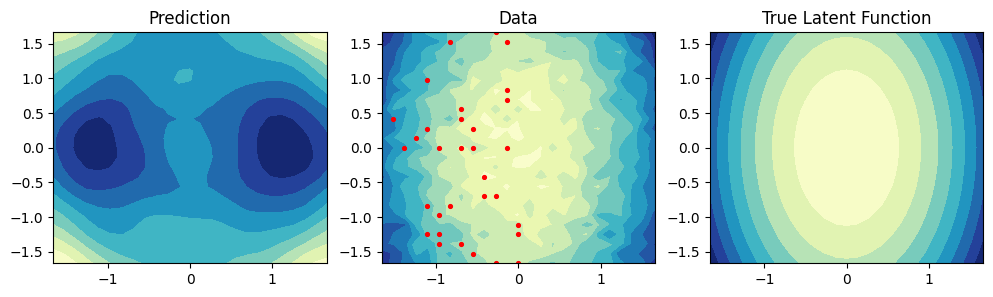

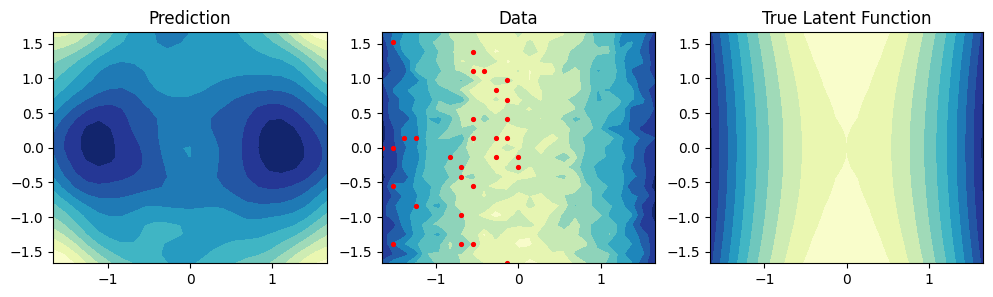

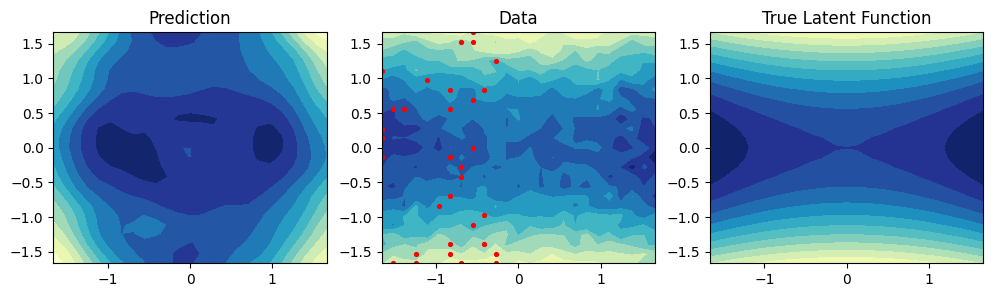

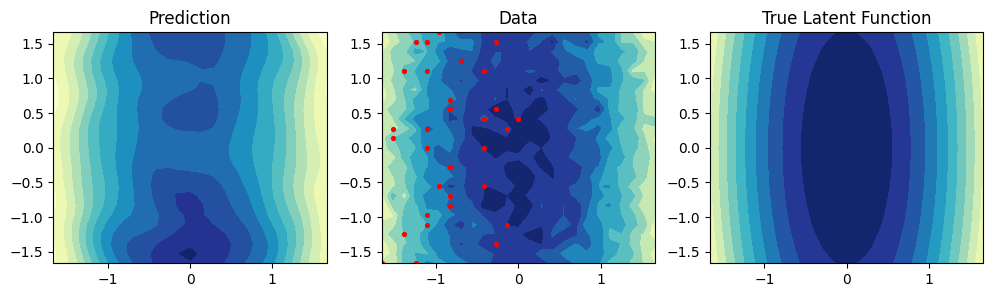

In [8]:
with tc.no_grad():
    (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()
    
plot(idx=0, grid=grids[0], ts=ts, pred=pred_strcgp, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)
plot(idx=1, grid=grids[0], ts=ts, pred=pred_strcgp, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)
plot(idx=4, grid=grids[0], ts=ts, pred=pred_strcgp, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)
plot(idx=8, grid=grids[0], ts=ts, pred=pred_strcgp, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)